<a href="https://colab.research.google.com/github/mohadeseh-ghafoori/GOES-Super-Resolution/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install satpy

In [ ]:
#!pip install GDAL
#from osgeo import gdal

In [ ]:
#!pip install s3fs

In [ ]:
#!pip install rasterio

In [6]:
from matplotlib import pyplot as plt
from satpy import Scene
from satpy.readers import FSFile
import fsspec
from glob import glob
import xarray as xr
import s3fs
import numpy as np
import pandas as pd
from osgeo import gdal
import rasterio

#Load summaries of VIIRS-detected fire hotspots

In [9]:
df=pd.read_csv('/content/drive/MyDrive/viirs-snpp_2019_United_States.csv', sep=',')
df

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,39.442356,-78.593529,303.97,0.51,0.50,2019-01-01,633,N,VIIRS,n,1,277.29,1.77,N,0
1,36.229572,-76.331787,297.75,0.54,0.42,2019-01-01,634,N,VIIRS,n,1,280.70,0.33,N,0
2,35.164753,-78.014725,302.29,0.43,0.46,2019-01-01,634,N,VIIRS,n,1,277.23,0.24,N,0
3,32.466473,-81.363434,304.59,0.62,0.54,2019-01-01,635,N,VIIRS,n,1,286.79,1.24,N,0
4,33.013569,-79.887283,327.08,0.51,0.50,2019-01-01,635,N,VIIRS,n,1,284.94,2.79,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447306,42.768929,-123.220657,343.06,0.42,0.38,2019-12-31,2053,N,VIIRS,n,1,278.66,12.12,D,0
447307,42.765507,-123.219635,335.40,0.42,0.38,2019-12-31,2053,N,VIIRS,n,1,280.60,7.25,D,0
447308,42.875229,-122.922440,332.39,0.41,0.37,2019-12-31,2053,N,VIIRS,n,1,283.71,2.67,D,0
447309,43.456131,-121.759857,342.97,0.39,0.36,2019-12-31,2053,N,VIIRS,n,1,280.55,5.74,D,0


In [10]:
wpl=['Kincade',-122.780 ,38.792,'2019-10-23','2019-11-06']
c=0.6 #degrees

In [11]:
df['acq_time']=df['acq_time'].apply(lambda x: str(x).zfill(4))
df['acq_time']=pd.to_datetime(df['acq_time'], format='%H%M').dt.time.astype(str)
df['acq_date']=df["acq_date"].astype(str)
df['datetime']=pd.to_datetime(df['acq_date']+' '+df['acq_time'])


In [12]:
df

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,datetime
0,39.442356,-78.593529,303.97,0.51,0.50,2019-01-01,06:33:00,N,VIIRS,n,1,277.29,1.77,N,0,2019-01-01 06:33:00
1,36.229572,-76.331787,297.75,0.54,0.42,2019-01-01,06:34:00,N,VIIRS,n,1,280.70,0.33,N,0,2019-01-01 06:34:00
2,35.164753,-78.014725,302.29,0.43,0.46,2019-01-01,06:34:00,N,VIIRS,n,1,277.23,0.24,N,0,2019-01-01 06:34:00
3,32.466473,-81.363434,304.59,0.62,0.54,2019-01-01,06:35:00,N,VIIRS,n,1,286.79,1.24,N,0,2019-01-01 06:35:00
4,33.013569,-79.887283,327.08,0.51,0.50,2019-01-01,06:35:00,N,VIIRS,n,1,284.94,2.79,N,2,2019-01-01 06:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447306,42.768929,-123.220657,343.06,0.42,0.38,2019-12-31,20:53:00,N,VIIRS,n,1,278.66,12.12,D,0,2019-12-31 20:53:00
447307,42.765507,-123.219635,335.40,0.42,0.38,2019-12-31,20:53:00,N,VIIRS,n,1,280.60,7.25,D,0,2019-12-31 20:53:00
447308,42.875229,-122.922440,332.39,0.41,0.37,2019-12-31,20:53:00,N,VIIRS,n,1,283.71,2.67,D,0,2019-12-31 20:53:00
447309,43.456131,-121.759857,342.97,0.39,0.36,2019-12-31,20:53:00,N,VIIRS,n,1,280.55,5.74,D,0,2019-12-31 20:53:00


#Extract wildfire event

In [13]:
#df_copy=df.copy()
roi = df[
    ((wpl[2] - c < df['latitude']) & (df['latitude'] < wpl[2] + c)) &
    ((wpl[1] - c < df['longitude']) & (df['longitude'] < wpl[1] + c)) &
    ((df['acq_date']>=wpl[3]) & (df['acq_date']<=wpl[4]))
]


In [14]:
roi

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,datetime
399170,38.744591,-122.808716,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,356.03,560.06,N,0,2019-10-24 09:05:00
399171,38.744446,-122.803154,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,380.00,560.06,N,0,2019-10-24 09:05:00
399172,38.744320,-122.798248,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,352.95,232.09,N,0,2019-10-24 09:05:00
399173,38.744038,-122.787102,314.85,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,292.45,24.85,N,0,2019-10-24 09:05:00
399174,38.743870,-122.780724,302.90,0.54,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,291.74,24.85,N,0,2019-10-24 09:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410516,39.332623,-122.247917,338.69,0.56,0.69,2019-11-05,20:02:00,N,VIIRS,n,1,287.67,3.17,D,0,2019-11-05 20:02:00
410520,39.337971,-122.248474,367.00,0.56,0.69,2019-11-05,20:02:00,N,VIIRS,h,1,291.65,14.97,D,0,2019-11-05 20:02:00
410522,39.338657,-122.250862,367.00,0.56,0.69,2019-11-05,20:02:00,N,VIIRS,h,1,290.37,8.52,D,0,2019-11-05 20:02:00
410640,39.337444,-122.244530,339.14,0.56,0.51,2019-11-05,21:43:00,N,VIIRS,n,1,297.31,4.69,D,0,2019-11-05 21:43:00


#Identify unique timestamps

In [15]:
unique_datetime=roi['datetime'].unique()
unique_datetime

array(['2019-10-24T09:05:00.000000000', '2019-10-24T10:46:00.000000000',
       '2019-10-24T20:27:00.000000000', '2019-10-24T22:08:00.000000000',
       '2019-10-25T10:27:00.000000000', '2019-10-25T20:08:00.000000000',
       '2019-10-25T20:09:00.000000000', '2019-10-25T21:49:00.000000000',
       '2019-10-26T10:08:00.000000000', '2019-10-26T21:30:00.000000000',
       '2019-10-27T09:49:00.000000000', '2019-10-27T21:11:00.000000000',
       '2019-10-28T09:30:00.000000000', '2019-10-28T11:10:00.000000000',
       '2019-10-28T11:11:00.000000000', '2019-10-28T20:52:00.000000000',
       '2019-10-29T09:11:00.000000000', '2019-10-29T10:52:00.000000000',
       '2019-10-29T20:33:00.000000000', '2019-10-29T22:14:00.000000000',
       '2019-10-30T08:52:00.000000000', '2019-10-30T10:33:00.000000000',
       '2019-10-31T10:14:00.000000000', '2019-10-31T21:36:00.000000000',
       '2019-11-01T09:56:00.000000000', '2019-11-03T20:40:00.000000000',
       '2019-11-05T10:21:00.000000000', '2019-11-05

#Group VIIRS by unique timestamps

In [16]:
groups = roi.groupby('datetime')
#iterate over groups
group_list=[groups.get_group(unique_datetime[i]) for i in range(len(unique_datetime))]
group_list[0]

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,datetime
399170,38.744591,-122.808716,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,356.03,560.06,N,0,2019-10-24 09:05:00
399171,38.744446,-122.803154,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,380.00,560.06,N,0,2019-10-24 09:05:00
399172,38.744320,-122.798248,367.00,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,h,1,352.95,232.09,N,0,2019-10-24 09:05:00
399173,38.744038,-122.787102,314.85,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,292.45,24.85,N,0,2019-10-24 09:05:00
399174,38.743870,-122.780724,302.90,0.54,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,291.74,24.85,N,0,2019-10-24 09:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399333,38.770496,-122.824081,308.60,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,292.08,3.20,N,0,2019-10-24 09:05:00
399334,38.770294,-122.816284,319.28,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,293.80,3.20,N,0,2019-10-24 09:05:00
399335,38.770061,-122.807350,307.69,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,291.88,3.09,N,0,2019-10-24 09:05:00
399336,38.769661,-122.792038,300.70,0.55,0.68,2019-10-24,09:05:00,N,VIIRS,n,1,289.59,6.57,N,0,2019-10-24 09:05:00


In [ ]:
import os

#save in a directory named "group_csv_files"
output_dir = "group_csv_files"
os.makedirs(output_dir, exist_ok=True)
for i, group in enumerate(group_list):
    file_name = f"group_{i}.csv"  # create a meaningful file name
    file_path = os.path.join(output_dir, file_name)
    group.to_csv(file_path, index=False)

#Rasterize VIIRS CSV file

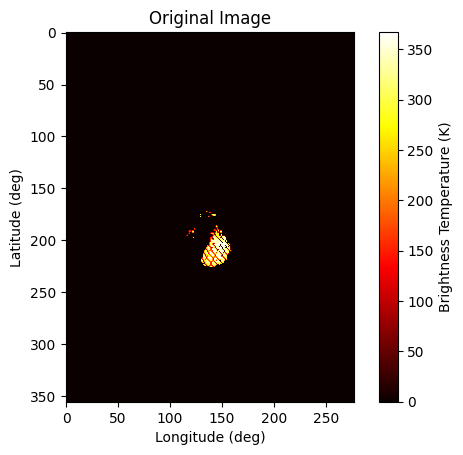

In [18]:
import pandas as pd
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator


#Define the ROI for the wildfire site
C = 0.6 # Constant value to add/subtract from the center coordinates
center_lon, center_lat = wpl[1], wpl[2] # Center coordinates of the fire site
roi_lon_min = center_lon - C # Minimum longitude of the ROI
roi_lon_max = center_lon + C # Maximum longitude of the ROI
roi_lat_min = center_lat - C # Minimum latitude of the ROI
roi_lat_max = center_lat + C # Maximum latitude of the ROI

#Overlay grid system over the ROI
cell_size = 375 # Cell size in meters
crs_wgs = pyproj.CRS("EPSG:4326") # Coordinate reference system for WGS84
crs_utm = pyproj.CRS("EPSG:32610") # Coordinate reference system for UTM zone 10N
transformer = pyproj.Transformer.from_crs(crs_wgs, crs_utm, always_xy=True) # Transformer function
roi_x_min, roi_y_min = transformer.transform(roi_lon_min, roi_lat_min) # Minimum x and y values of the ROI in UTM
roi_x_max, roi_y_max = transformer.transform(roi_lon_max, roi_lat_max) # Maximum x and y values of the ROI in UTM
x_range = np.arange(roi_x_min, roi_x_max, cell_size) # Range of x values for the grid
y_range = np.arange(roi_y_min, roi_y_max, cell_size) # Range of y values for the grid
x_grid, y_grid = np.meshgrid(x_range, y_range) # Grid of x and y values

#Map the fire locations from the CSV file to the corresponding pixels
#csv_file = "/content/group_csv_files/group_10.csv"
#csv_file = group_list[10]
#fire_csv = pd.read_csv(csv_file)
fire_csv = group_list[10]
fire_lon = fire_csv["longitude"].values
fire_lat = fire_csv["latitude"].values
fire_temp = fire_csv["bright_ti4"].values
fire_x, fire_y = transformer.transform(fire_lon, fire_lat) # Transform fire coordinates to UTM
output_image = np.zeros((len(y_range), len(x_range))) # Initialize output image as a zero matrix
for i in range(len(fire_x)): # Loop through each fire location
  x_index = np.argmin(np.abs(x_range - fire_x[i])) # Find the closest x value in the grid
  y_index = np.argmin(np.abs(y_range - fire_y[i])) # Find the closest y value in the grid
  #output_image[y_index, x_index] = fire_temp[i] # Assign the fire temperature value to the pixel
  output_image[len(y_range)-y_index-1, x_index] = fire_temp[i] # Assign the fire temperature value to the pixel


#Plot
plt.imshow(output_image, cmap="hot")#, origin="lower", extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
#plt.imshow(output_image, cmap="hot", origin="lower", extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
plt.colorbar(label="Brightness Temperature (K)")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Original Image")
plt.show()

#Interpolate non-fire pixel with neighboring fire pixel

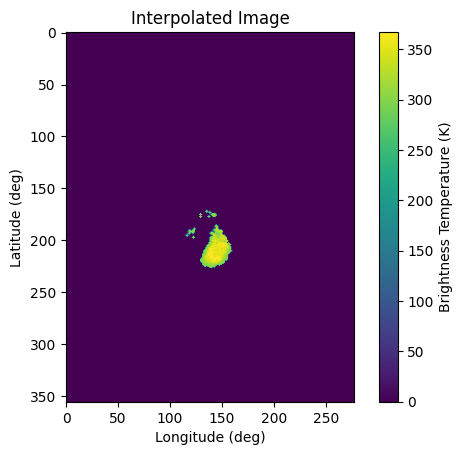

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

output_image_interp = output_image.copy()

# Generate coordinates of the patchy region
#y, x = np.where(output_image==0)
x=[]
y=[]
for i in range(output_image_interp.shape[0]):
  for j in range(output_image_interp.shape[1]):
    if i!=0 and i!=(output_image_interp.shape[0]-1) and j!=0 and j!=(output_image_interp.shape[1]-1):
      if output_image_interp[i,j]==0 and (output_image_interp[i,j+1]!=0 or output_image_interp[i,j-1]!=0
                          or output_image_interp[i+1,j]!=0 or output_image_interp[i-1,j]!=0):
                          #or output_image_interp[i+1,j-1]!=0 or output_image_interp[i-1,j-1]!=0
                          #or output_image_interp[i+1,j+1]!=0 or output_image_interp[i-1,j+1]!=0):
        y.append(i)
        x.append(j)


# Generate coordinates of the known values
y_known, x_known = np.where(output_image!=0)

# Extract values of known pixels
values_known = output_image_interp[y_known, x_known]

# Create the interpolator
interpolator = NearestNDInterpolator((y_known, x_known), values_known)

# Interpolate the patchy region
values_interpolated = interpolator(y, x)

# Replace Zero values with the interpolated values
output_image_interp[y, x] = values_interpolated

# Visualize the result
plt.imshow(output_image_interp,cmap="viridis")#, origin="lower", extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
plt.colorbar(label="Brightness Temperature (K)")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Interpolated Image")
plt.show()


In [20]:
diff=output_image_interp-output_image
diff.sum()

97413.08000000002

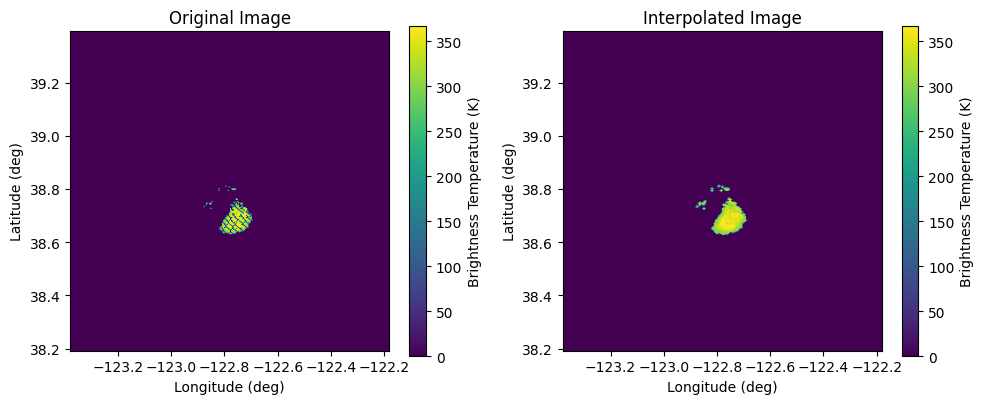

In [22]:

# Create two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first image
im1 = axes[0].imshow(output_image, cmap='viridis', extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
axes[0].set_title("Original Image")
axes[0].set_xlabel("Longitude (deg)")
axes[0].set_ylabel("Latitude (deg)")

# Add colorbar for the first image
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label(label="Brightness Temperature (K)")

# Plot the second image
im2 = axes[1].imshow(output_image_interp, cmap='viridis', extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
axes[1].set_title("Interpolated Image")
axes[1].set_xlabel("Longitude (deg)")
axes[1].set_ylabel("Latitude (deg)")

# Add colorbar for the second image
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label(label="Brightness Temperature (K)")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



#Save VIIRS raster GeoTIFF file with GDAL

In [28]:
from osgeo import gdal
output_tiff = 'output_raster.tif'
#Get the driver object for the GeoTIFF format
driver = gdal.GetDriverByName('GTiff')
#dst_ds = driver.Create(output_tiff, x_grid.shape[1], y_grid.shape[0], 1, gdal.GDT_Float32)
dst_ds = driver.Create(output_tiff, xsize=output_image_interp.shape[1], ysize=output_image_interp.shape[0], bands=1, eType=gdal.GDT_Float32)
#dst_ds = driver.Create(output_tiff, xsize=128, ysize=128, bands=1, eType=gdal.GDT_Float32)


pixel_width = pixel_height = resolution= cell_size = 375
ulx, uly = x_grid.min(), y_grid.max()
#Set the geotransform parameters for the dataset
#The first and fourth arguments are the x and y coordinates of the upper left corner of the raster
#The second and sixth arguments are the pixel width and height in map units
#The third and fifth arguments are the rotation parameters, which are zero for north-up rasters
dst_ds.SetGeoTransform((ulx, pixel_width, 0, uly, 0, -pixel_height))
#Define and set the projection of the raster as EPSG:4326, which is a standard code for WGS84 geographic coordinate system
projection = 'EPSG:4326'
dst_ds.SetProjection(projection)
#crop the whole image into a 128*128 image around its center
# arr=output_image_interp.copy()
# height, width = arr.shape[:2]

#Calculate the coordinates of the center of the image
# center_y = height // 2
# center_x = width // 2

#Calculate the coordinates of the box that defines the region to be cropped
#The box is a 4-tuple (top, left, bottom, right)
# top = center_y - 64 # 64 is half of 128
# left = center_x - 64
# bottom = center_y + 64
# right = center_x + 64

#Crop the image using array slicing
#cropped_array = arr[top:bottom, left:right].copy()

dst_ds.GetRasterBand(1).WriteArray(output_image_interp)
#Close the dataset and flush any changes to disk
dst_ds = None

#Download GOES images for each identified timestamp

In [23]:
unique_datetime=pd.Series(unique_datetime)
day_of_year=unique_datetime.dt.dayofyear
year=unique_datetime.dt.year
hour=unique_datetime.dt.hour
minute=unique_datetime.dt.minute

In [24]:
def GOES_time(year=None,day_of_year=None, hour=None , minute=None):
  valid_minutes=np.array([1,6,11,16,21,26,31,36,41,46,51,56])  #GOES special mintues
  goes_minute=0
  goes_hour=0
  goes_day=0
  goes_year=0
  if  minute>=0 and minute<=58 :
    diffs=valid_minutes-minute
    diffs=np.abs(diffs)
    min_id=np.argmin(diffs)
    goes_minute=valid_minutes[min_id]
    goes_hour=hour
    goes_day=day_of_year
    goes_year=year

  if minute==59:
    if hour==23:
      goes_minute=1 #next day
      goes_hour=0
      if day_of_year==365:
        goes_day=1  #next year
        goes_year=year+1
      else:
        goes_day=day_of_year+1  #same day
        goes_year=year

    else:
      goes_minute=1
      goes_hour=hour+1
      goes_day=day_of_year
      goes_year=year

  return goes_year,goes_day,goes_hour,goes_minute



In [25]:
fs_files=[]
for i in range(len(day_of_year)):
  #Convert the year, day, hour, and minute values to GOES time format
  goes_year,goes_day,goes_hour,goes_minute=GOES_time(year[i], day_of_year[i], hour[i] , minute[i])
  #Construct the filename pattern for the GOES-17 ABI-L1b-RadC product for band 7 (3.9 um)
  filename='s3://noaa-goes17/ABI-L1b-RadC/'+str(goes_year)+'/'+str(goes_day).zfill(3)+'/'+str(goes_hour).zfill(2)+'/OR_ABI-L1b-RadC-M6C07_G17_s'+str(goes_year)+str(goes_day).zfill(3)+str(goes_hour).zfill(2)+str(goes_minute).zfill(2)+'*'
  the_files=fsspec.open_files("simplecache::s3://" + filename, s3={'anon': True})
  fs_files.append([FSFile(open_file) for open_file in the_files])

fs_files


[[<FSFile "noaa-goes17/ABI-L1b-RadC/2019/297/09/OR_ABI-L1b-RadC-M6C07_G17_s20192970906196_e20192970908580_c20192970909055.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/297/10/OR_ABI-L1b-RadC-M6C07_G17_s20192971046196_e20192971048581_c20192971049022.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/297/20/OR_ABI-L1b-RadC-M6C07_G17_s20192972026196_e20192972028581_c20192972029052.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/297/22/OR_ABI-L1b-RadC-M6C07_G17_s20192972206196_e20192972208581_c20192972209053.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/298/10/OR_ABI-L1b-RadC-M6C07_G17_s20192981026196_e20192981028580_c20192981029073.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/298/20/OR_ABI-L1b-RadC-M6C07_G17_s20192982006196_e20192982008581_c20192982009030.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/298/20/OR_ABI-L1b-RadC-M6C07_G17_s20192982011196_e20192982013580_c20192982014013.nc">],
 [<FSFile "noaa-goes17/ABI-L1b-RadC/2019/298/21/OR_ABI-L1b-RadC-M6C07_G17_s20192982151196_e201929

In [26]:
#arr=np.array(fs_files)
k=[i for i in range(len(fs_files)) if len(fs_files[i])==0]
k

[]

#Reprojection of GOES images

Area ID: wgs84_area
Description: wgs84_area
Projection: {'datum': 'WGS84', 'no_defs': 'None', 'proj': 'longlat', 'type': 'crs'}
Number of columns: 278
Number of rows: 356
Area extent: (-123.38, 38.192, -122.18, 39.392)


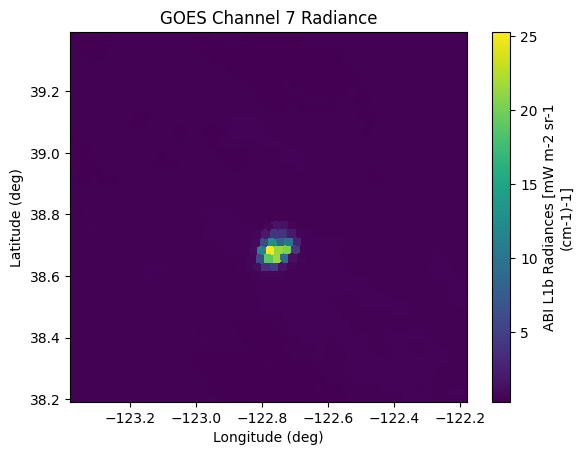

In [27]:
from satpy import Scene
from pyresample import create_area_def
from glob import glob
from matplotlib import pyplot as plt

# Load the ABI-L1b data
#filenames = glob('/content/OR_ABI-L1b-RadC-M6C07_G17_s20193000951196_e20193000953581_c20193000954024.nc')
filenames = fs_files[10]
scn = Scene(reader='abi_l1b', filenames=filenames)
my_channel='C07'
scn.load([my_channel],calibration=['radiance'])
#crop_scn = scn.crop(ll_bbox=(-123.38, 38.192, -122.18, 39.392))
# Define the area in WGS84 coordinates
wgs84_area = create_area_def('wgs84_area', projection='EPSG:4326' ,# resolution=0.01,
                             width=output_image_interp.shape[1], height=output_image_interp.shape[0],
                             #width=128, height=128,
                             area_extent=[roi_lon_min, roi_lat_min, roi_lon_max, roi_lat_max], units='degrees')

print(wgs84_area)
# Resample the data to the new area definition
new_scn = scn.resample(wgs84_area)

# Access the resampled data
resampled_data = new_scn['C07']

# Plot the resampled data
plt.figure()
resampled_data.plot.imshow(cmap='viridis')
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("GOES Channel 7 Radiance")
plt.show()

#Read VIIRS GeoTIFF file

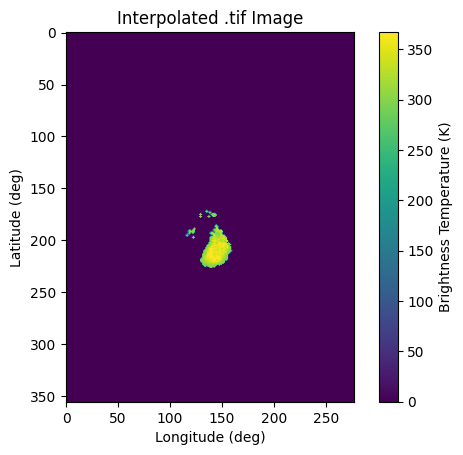

In [29]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as npy
data_set = gdal.Open('/content/output_raster.tif')
#access band to access data
band = data_set.GetRasterBand(1)
array = band.ReadAsArray()
plt.figure()
plt.imshow(array)#, origin="lower",extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Interpolated .tif Image")
plt.colorbar(label="Brightness Temperature (K)")
plt.show()

In [30]:
proj=data_set.GetProjection()
proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

#Overlapped Images

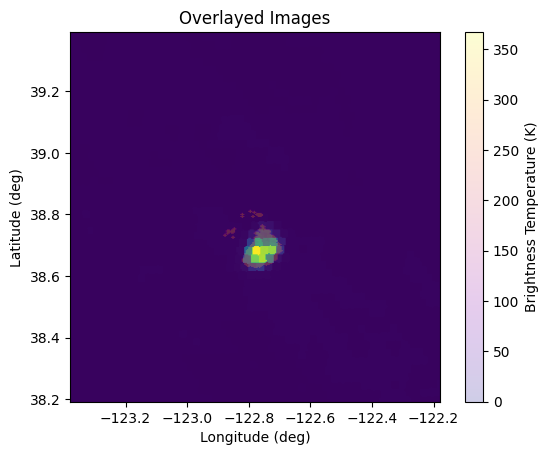

In [32]:
import matplotlib.pyplot as plt
import numpy as np


# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first image
im1 = ax.imshow(resampled_data, cmap='viridis',extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])  # Set alpha to control transparency

# Plot the second image on top of the first one
im2 = ax.imshow(array , cmap='plasma',alpha=0.2,extent=[roi_lon_min, roi_lon_max, roi_lat_min, roi_lat_max])  # Set alpha to control transparency

# Add colorbar (optional)
cbar = fig.colorbar(im2, ax=ax)
cbar.set_label(label="Brightness Temperature (K)")

# Set title and labels
ax.set_title('Overlayed Images')
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")

# Show the plot
plt.show()
